In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators.calculation import CalculationValidator

%matplotlib inline

## 1. Load Data
Load the portfolio data from the CSV file.

In [2]:
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions.")

Loaded 7721 positions.


## 2. Run Calculation Validator
We run the validator to find rows where `Value in USD` != `Quantity` * `Price` * `Exchange Rate`.

**Note:** Rows where the theoretical value is zero (due to missing Price, Quantity, or FX) are **excluded** from this analysis. We focus strictly on logic errors (wrong multipliers, sign mismatches) rather than data availability issues.

In [3]:
validator = CalculationValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} calculation errors.")

if errors:
    # Convert to DataFrame for easier analysis
    error_df = pd.DataFrame([vars(e) for e in errors])
    
    # Show distribution of severity
    print("\nSeverity Distribution:")
    print(error_df['severity'].value_counts())
    
    display(error_df.head(10))
else:
    print("No calculation errors found.")

Found 620 calculation errors.

Severity Distribution:
severity
Low       597
Medium     15
High        8
Name: count, dtype: int64


,date,ticker,error_type,description,severity
0,2022-01-03,ANTO,Calculation Error,Value Mismatch: Reported -30773.39 vs Calc -22...,Low
1,2022-01-04,ANTO,Calculation Error,Value Mismatch: Reported -31588.64 vs Calc -23...,Low
2,2022-01-05,ANTO,Calculation Error,Value Mismatch: Reported -31873.42 vs Calc -23...,Low
3,2022-01-06,ANTO,Calculation Error,Value Mismatch: Reported -30683.04 vs Calc -22...,Low
4,2022-01-07,ANTO,Calculation Error,Value Mismatch: Reported -31565.09 vs Calc -23...,Low
5,2022-01-10,ANTO,Calculation Error,Value Mismatch: Reported -41696.68 vs Calc -30...,Low
6,2022-01-19,ANTO,Calculation Error,Value Mismatch: Reported -22236.94 vs Calc -16...,Low
7,2022-02-04,ANTO,Calculation Error,Value Mismatch: Reported -19471.09 vs Calc -14...,Low
8,2022-02-07,ANTO,Calculation Error,Value Mismatch: Reported -19578.36 vs Calc -14...,Low
9,2022-02-08,ANTO,Calculation Error,Value Mismatch: Reported -19861.40 vs Calc -14...,Low


In [4]:
error_df[error_df["severity"]=="High"].head()

,date,ticker,error_type,description,severity
36,2022-03-04,RHM,Calculation Error,Value Mismatch: Reported 121400.22 vs Calc -94...,High
38,2022-03-07,RHM,Calculation Error,Value Mismatch: Reported 126674.96 vs Calc -99...,High
491,2022-10-25,TEG,Calculation Error,Value Mismatch: Reported 99404.65 vs Calc 7162...,High
496,2022-10-26,TEG,Calculation Error,Value Mismatch: Reported 99404.65 vs Calc 7250...,High
500,2022-10-27,QQQ,Calculation Error,Value Mismatch: Reported -134252.04 vs Calc 29...,High


## 3. Visualization
We visualize the magnitude of the discrepancies. Since these are point-in-time errors (not time-series anomalies), a scatter plot of `Reported Value` vs `Calculated Value` is effective. Points off the diagonal line indicate errors.

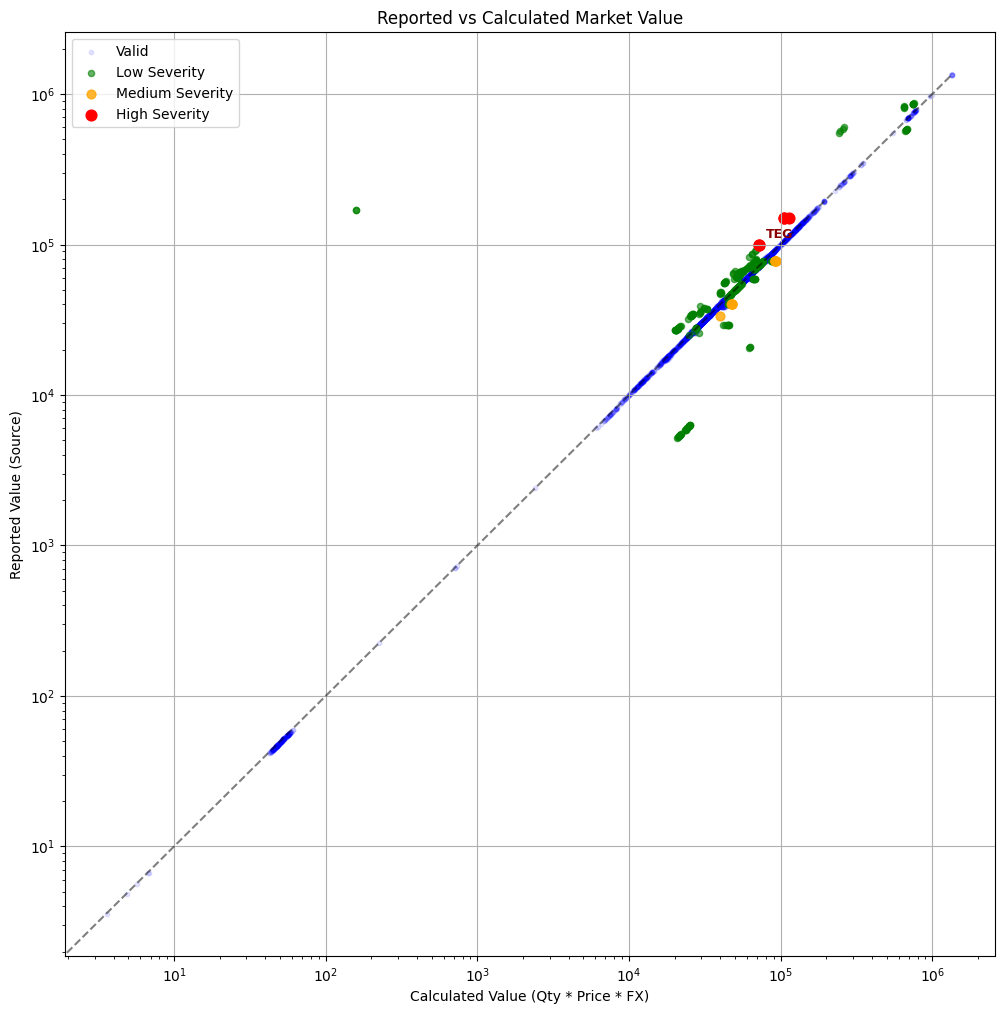

In [5]:
if errors:
    # Re-calculate for plotting context
    df = positions.copy()
    cols = ["Close Quantity", "Price", "Exchange Rate", "Value in USD"]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
    df["Theoretical_Value"] = df["Close Quantity"] * df["Price"] * df["Exchange Rate"]
    df["Diff"] = (df["Value in USD"] - df["Theoretical_Value"]).abs()
    
    plt.figure(figsize=(12, 12))
    
    # 1. Plot "Valid" points (Not in errors list)
    error_keys = set((e.date, e.ticker) for e in errors)
    is_error = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
    valid_data = df[~is_error]
    
    plt.scatter(valid_data["Theoretical_Value"], valid_data["Value in USD"], 
                alpha=0.1, c='blue', label='Valid', s=10)
    
    # 2. Plot Errors by Severity
    error_df = pd.DataFrame([vars(e) for e in errors])
    error_df['Date'] = pd.to_datetime(error_df['date'])
    error_df['P_Ticker'] = error_df['ticker']
    
    plot_errors = pd.merge(error_df, df, on=['Date', 'P_Ticker'], how='left')
    
    high = plot_errors[plot_errors['severity'] == 'High']
    med = plot_errors[plot_errors['severity'] == 'Medium']
    low = plot_errors[plot_errors['severity'] == 'Low']
    
    plt.scatter(low["Theoretical_Value"], low["Value in USD"], c='green', label='Low Severity', s=20, alpha=0.6)
    plt.scatter(med["Theoretical_Value"], med["Value in USD"], c='orange', label='Medium Severity', s=40, alpha=0.8)
    plt.scatter(high["Theoretical_Value"], high["Value in USD"], c='red', label='High Severity', s=60, alpha=1.0)
    
    # Annotate High Severity Errors
    # We only annotate a few to avoid clutter
    annotated_tickers = set()
    for idx, row in high.iterrows():
        if row['P_Ticker'] not in annotated_tickers:
            plt.annotate(f"{row['P_Ticker']}", 
                         (row['Theoretical_Value'], row['Value in USD']),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=9, color='darkred', fontweight='bold')
            annotated_tickers.add(row['P_Ticker'])
            if len(annotated_tickers) >= 10: break # Limit annotations

    # Diagonal line
    max_val = max(df["Theoretical_Value"].max(), df["Value in USD"].max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    plt.title("Reported vs Calculated Market Value")
    plt.xlabel("Calculated Value (Qty * Price * FX)")
    plt.ylabel("Reported Value (Source)")
    plt.legend()
    plt.grid(True)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.show()

## 4. Time Series Impact Analysis
We visualize the time series of the ticker with the highest calculation error to see the impact of the discrepancy over time. This helps distinguish between a one-off data glitch and a persistent issue.

Found 8 High Severity errors across 3 tickers.
Visualizing top 3 most recurring high severity errors:
Visualizing ticker: TEG (Max Error: 29.7%, Count: 5)


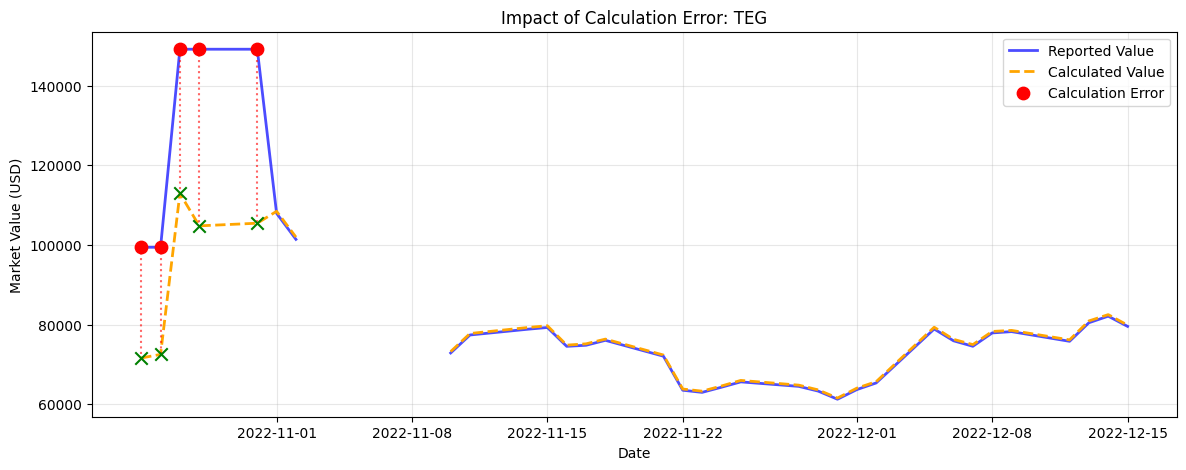

Visualizing ticker: RHM (Max Error: 178.2%, Count: 2)


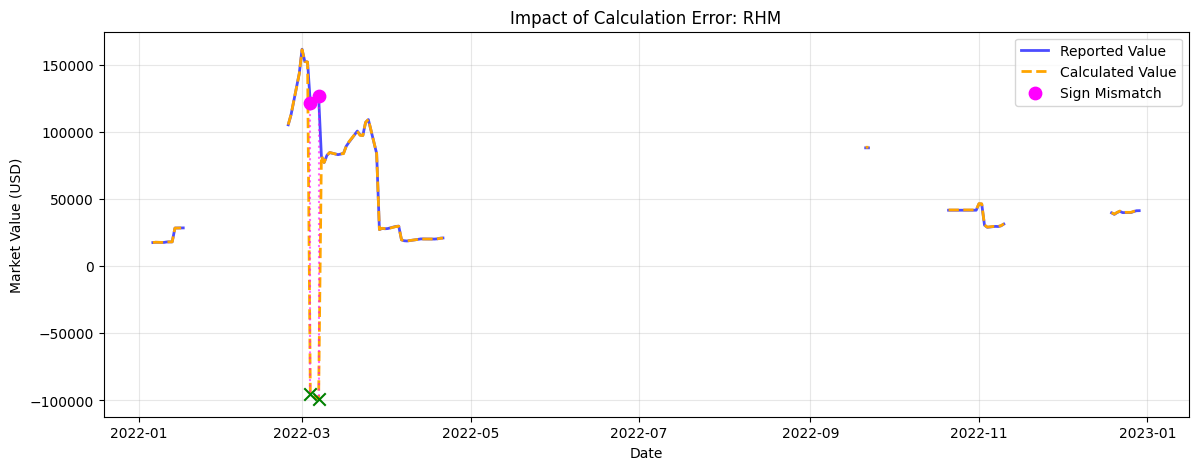

Visualizing ticker: QQQ (Max Error: 316.7%, Count: 1)


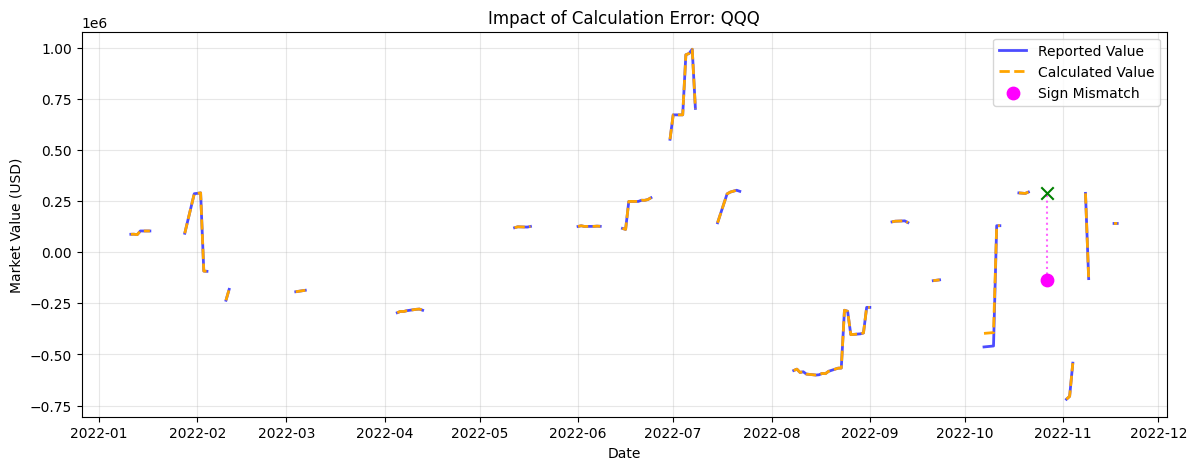

In [6]:
if errors:
    # Helper to clean and parse floats
    def clean_float(x):
        try:
            return float(str(x).replace(',', '').replace(' ', ''))
        except:
            return 0.0

    def visualize_ticker_error(ticker, error_list, positions_df):
        # Filter errors for this ticker
        ticker_errors = [e for e in error_list if e.ticker == ticker]
        if not ticker_errors:
            return

        # Find the max error for title
        max_pct_error = 0
        for e in ticker_errors:
             mask = (positions_df['Date'] == e.date) & (positions_df['P_Ticker'] == e.ticker)
             if not mask.any(): continue
             row = positions_df[mask].iloc[0]
             val_usd = clean_float(row['Value in USD'])
             qty = clean_float(row['Close Quantity'])
             price = clean_float(row['Price'])
             fx = clean_float(row['Exchange Rate'])
             calc_val = qty * price * fx
             
             if val_usd != 0:
                pct = abs(val_usd - calc_val) / abs(val_usd)
             else:
                pct = 0
             if pct > max_pct_error:
                max_pct_error = pct

        print(f"Visualizing ticker: {ticker} (Max Error: {max_pct_error:.1%}, Count: {len(ticker_errors)})")
        
        # Prepare data for plotting
        ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
        ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
        ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
        ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
        
        # Plot
        plt.figure(figsize=(14, 5))
        
        plt.plot(ticker_df['Date'], ticker_df['Reported'], label='Reported Value', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Calculated'], label='Calculated Value', color='orange', linestyle='--', linewidth=2)
        
        # Highlight ALL error points
        error_dates = [e.date for e in ticker_errors]
        error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
        
        if not error_points.empty:
            # Check error types
            is_sign_mismatch = any("Sign Mismatch" in e.description for e in ticker_errors)
            
            if is_sign_mismatch:
                color = 'magenta'
                label = 'Sign Mismatch'
            else:
                color = 'red'
                label = 'Calculation Error'
            
            plt.scatter(error_points['Date'], error_points['Reported'], color=color, s=80, zorder=5, label=label)
            plt.scatter(error_points['Date'], error_points['Calculated'], color='green', s=80, zorder=5, marker='x')
            
            # Draw lines for each error
            for _, row in error_points.iterrows():
                x_val = row['Date']
                y_rep = row['Reported']
                y_calc = row['Calculated']
                plt.plot([x_val, x_val], [y_rep, y_calc], color=color, linestyle=':', linewidth=1.5, alpha=0.6)

        plt.title(f"Impact of Calculation Error: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Market Value (USD)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Filter for High Severity errors
    high_severity_errors = [e for e in errors if e.severity == 'High']
    
    if high_severity_errors:
        # Count recurrence by ticker
        ticker_counts = {}
        for e in high_severity_errors:
            ticker_counts[e.ticker] = ticker_counts.get(e.ticker, 0) + 1
            
        # Sort by recurrence (most frequent first)
        sorted_tickers = sorted(ticker_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Take top 10
        top_tickers = [t[0] for t in sorted_tickers[:10]]
        
        print(f"Found {len(high_severity_errors)} High Severity errors across {len(ticker_counts)} tickers.")
        print(f"Visualizing top {len(top_tickers)} most recurring high severity errors:")
        
        for ticker in top_tickers:
            visualize_ticker_error(ticker, high_severity_errors, positions)
            
    else:
        print("No High Severity errors found.")

## 5. Systematic Discrepancy Analysis
We have identified that some tickers have consistent, systematic discrepancies (e.g., missing a constant multiplier or currency conversion). These have been downgraded to "Low" severity to separate them from genuine data glitches.

Below, we visualize these systematic errors to confirm they follow the same trend as the reported value, just offset by a factor.

Found 385 Systematic errors across 21 tickers.
Top systematic issues: ['PLUS', 'ANTO', '2GB', '2561', 'TGA']

Visualizing Systematic Error: PLUS


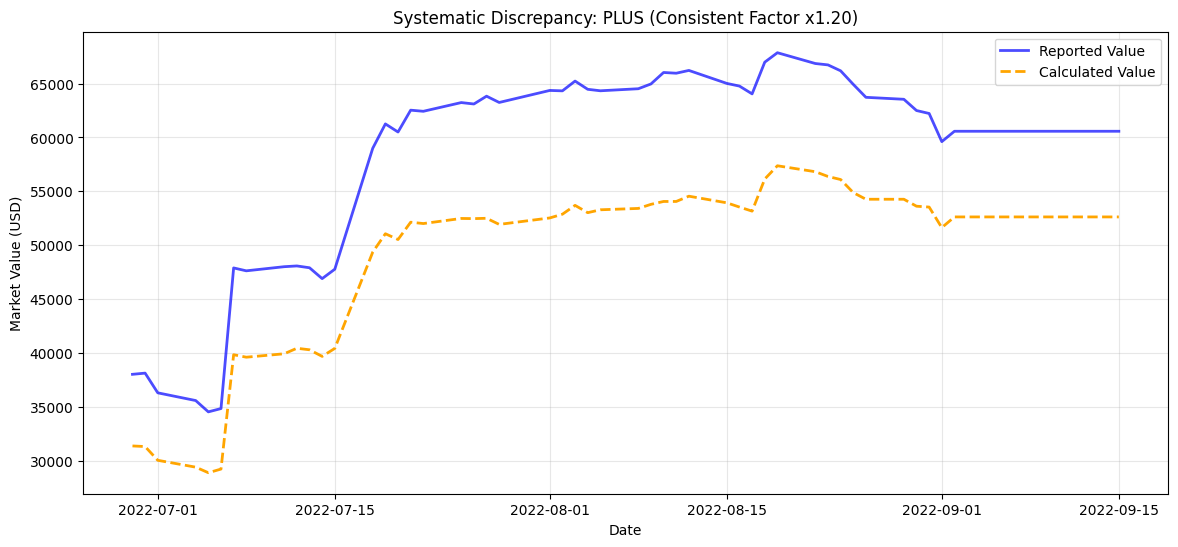

In [7]:
# Filter for Systematic Errors
systematic_errors = [e for e in errors if "Systematic Multiplier" in e.description]

if systematic_errors:
    # Count recurrence
    sys_counts = {}
    for e in systematic_errors:
        sys_counts[e.ticker] = sys_counts.get(e.ticker, 0) + 1
        
    sorted_sys = sorted(sys_counts.items(), key=lambda x: x[1], reverse=True)
    top_sys = [t[0] for t in sorted_sys[:5]]
    
    print(f"Found {len(systematic_errors)} Systematic errors across {len(sys_counts)} tickers.")
    print(f"Top systematic issues: {top_sys}")
    
    # Visualize the first one to show the "Parallel Trend"
    if top_sys:
        example_ticker = top_sys[0]
        print(f"\nVisualizing Systematic Error: {example_ticker}")
        
        # Reuse the visualization function
        # We need to define it if it wasn't defined in the previous cell (it was defined inside the if block)
        # So let's redefine/extract it or just copy logic for safety
        
        ticker_df = positions[positions['P_Ticker'] == example_ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        def clean_float(x):
            try:
                return float(str(x).replace(',', '').replace(' ', ''))
            except:
                return 0.0

        ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
        ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
        ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
        ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
        
        plt.figure(figsize=(14, 6))
        plt.plot(ticker_df['Date'], ticker_df['Reported'], label='Reported Value', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Calculated'], label='Calculated Value', color='orange', linestyle='--', linewidth=2)
        
        # Extract multiplier from description of the first error for this ticker
        example_error = next(e for e in systematic_errors if e.ticker == example_ticker)
        import re
        match = re.search(r"x([\d\.]+)", example_error.description)
        mult = match.group(1) if match else "?"
        
        plt.title(f"Systematic Discrepancy: {example_ticker} (Consistent Factor x{mult})")
        plt.xlabel("Date")
        plt.ylabel("Market Value (USD)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No Systematic errors found.")